In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('Amazon-Product-Review-Sentiment-Analysis-using-RNN-Dataset.csv')
data.head(3)

,Review,Sentiment
0,Fast shipping but this product is very cheaply...,1
1,This case takes so long to ship and it's not e...,1
2,Good for not droids. Not good for iPhones. You...,1


In [3]:
data.shape

(25000, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [5]:
data.isna().sum()

Review       1
Sentiment    0
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data['Sentiment'].value_counts()

Sentiment
1    5000
2    5000
3    5000
4    5000
5    4999
Name: count, dtype: int64

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     WRONG_VERSION_NUMBER] wrong version number
[nltk_data]     (_ssl.c:1006)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     WRONG_VERSION_NUMBER] wrong version number
[nltk_data]     (_ssl.c:1006)>


False

In [9]:
stop_words=set(stopwords.words('english'))
def clean_reviews(text):
    # Correct regex pattern for HTML tags
    regex = re.compile('<.*?>')
    text = re.sub(regex, '', text)
    
    # Remove digits
    pattern = re.compile('\d+')
    text = re.sub(pattern, '', text)
    
    # Remove stopwords
    text = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(text)

# Applying the function to your 'Review' column
data['Review'] = data['Review'].apply(clean_reviews)

In [10]:
tokenizer=Tokenizer()
review_to_list=data['Review'].tolist()
tokenizer.fit_on_texts(review_to_list)

text_sequence=tokenizer.texts_to_sequences(review_to_list)
max_words=500
padded_sequence=pad_sequences(text_sequence,maxlen=max_words)
text_sequence=pad_sequences(padded_sequence)

data=pd.get_dummies(data, columns=['Sentiment'])

x=pad_sequences(text_sequence,maxlen=max_words)
y=data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4', 'Sentiment_5']]


In [11]:
print(x.shape,y.shape)

(24999, 500) (24999, 5)


In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


In [13]:
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,max_words,input_length=max_words))
rnn.add(SimpleRNN(128,activation='relu',return_sequences=True))
rnn.add(SimpleRNN(64,activation='relu',return_sequences=False))
rnn.add(Dense(5, activation='softmax'))
# printing model summary
print(rnn.summary())

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

history=rnn.fit(x_train,y_train,batch_size=64,epochs=2,verbose=1,validation_data=(x_test, y_test))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 240s 743ms/step - accuracy: 0.3086 - loss: 1.4822 - val_accuracy: 0.4400 - val_loss: 1.2716
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 251s 802ms/step - accuracy: 0.5316 - loss: 1.0935 - val_accuracy: 0.4090 - val_loss: 1.3211


In [15]:
print("RNN score -> ",rnn.evaluate(x_test,y_test,verbose=1))

157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.4053 - loss: 1.3336
RNN score ->  [1.3211501836776733, 0.4090000092983246]


In [16]:
model=Sequential(name='LSTM_model')
model.add(Embedding(len(tokenizer.word_index)+1,max_words,input_length=max_words))
model.add(LSTM(150,return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

model.add(Dense(50,activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

In [17]:
print(model.summary())

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)
history=rnn.fit(x_train,y_train,batch_size=64,epochs=3,verbose=1,validation_data=(x_test, y_test))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 232s 741ms/step - accuracy: 0.6855 - loss: 0.8006 - val_accuracy: 0.4168 - val_loss: 1.4525
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 247s 790ms/step - accuracy: 0.8153 - loss: 0.5171 - val_accuracy: 0.4198 - val_loss: 1.7480
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 246s 787ms/step - accuracy: 0.8912 - loss: 0.3133 - val_accuracy: 0.3964 - val_loss: 2.0843


In [19]:
print("LsTM model score-> ",model.evaluate(x_test,y_test,verbose=1))

157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.2008 - loss: 1.6098
LsTM model score->  [1.609620451927185, 0.20160000026226044]


Text(0, 0.5, 'Accuracy')

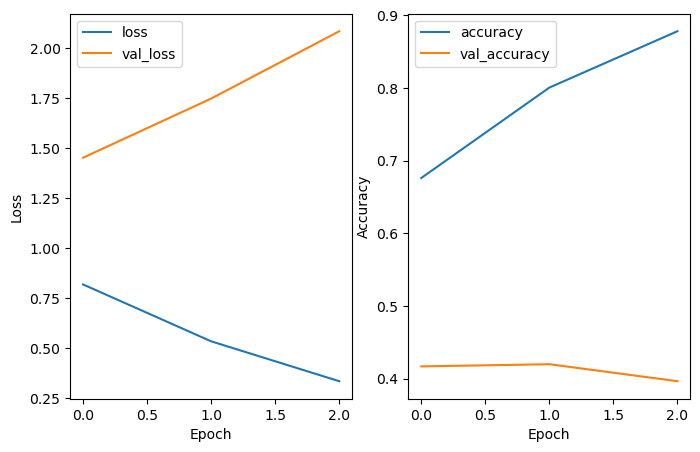

In [21]:
metrics=history.history
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.plot(history.epoch,metrics['loss'],metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(history.epoch,metrics['accuracy'],metrics['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 200ms/step


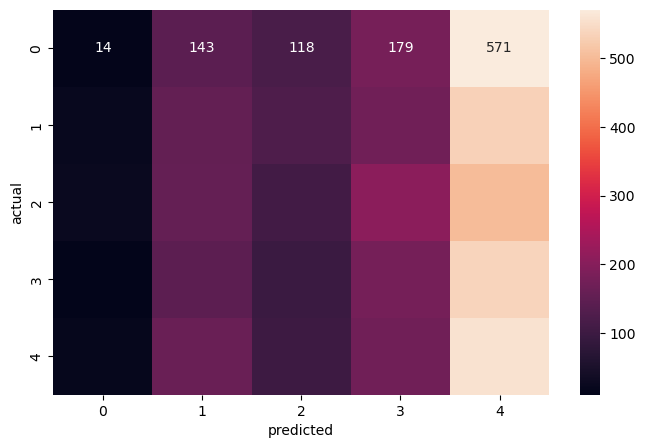

In [22]:
y_true=np.argmax(y_test.values,axis=1)
y_true.shape
y_pred=np.argmax(model.predict(x_test),axis=1)
cm=tf.math.confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm,annot=True,fmt='g')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [23]:
from sklearn.metrics import classification_report
report=classification_report(y_true,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.16      0.01      0.03      1025
           1       0.20      0.15      0.17      1005
           2       0.20      0.11      0.14       996
           3       0.20      0.18      0.19       967
           4       0.21      0.55      0.30      1007

    accuracy                           0.20      5000
   macro avg       0.19      0.20      0.17      5000
weighted avg       0.19      0.20      0.16      5000



In [24]:
def predict_review_rating(text):
    text_sequence_test=np.array(tokenizer.texts_to_sequences([text]))
    testing=pad_sequences(text_sequence_test,maxlen=max_words)
    y_pred_test=np.argmax(model.predict(testing),axis=1)
    return y_pred_test[0]+1


In [34]:
rating1=predict_review_rating("good product,but i can recommend to other")
print("The rating according to the review is:",rating1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
The rating according to the review is: 1


In [35]:
rating2 = predict_review_rating('Awesome product,  I will recommend this to other users.')
print("The rating according to the review is: ", rating2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
The rating according to the review is:  4
